
----
# Cuaderno 8 - Árboles de Decisión
## Ariel Palazzesi - 2026
----


En este cuaderno vamos a construir y analizar un modelo de clasificación utilizando un **árbol de decisión**.

Utilizaremos el dataset del Titanic para predecir si una persona sobrevivió o no (`Survived`) en función de características como edad, clase del pasaje, sexo y cantidad de familiares a bordo.

A lo largo del cuaderno:
- Entrenaremos un árbol sin limitar su profundidad.
- Visualizaremos su estructura para entender cómo toma decisiones.
- Evaluaremos su rendimiento con las métricas conocidas.
- Compararemos el árbol completo con uno limitado en profundidad para ver cómo afecta eso al rendimiento y al sobreajuste.


## Árboles de Decisión:

Tal como hemos hecho en otros cuadernos, antes de comenzar veamos la idea general y funcionamiento de los **Árboles de Decisión**

Un **Árbol de Decisión** es un algoritmo de **aprendizaje supervisado** que se utiliza tanto para **clasificación** como para regresión. Su funcionamiento se basa en una idea muy intuitiva: **tomar decisiones paso a paso mediante preguntas simples**, de forma similar a un diagrama de flujo o a un árbol de decisiones cotidiano.

El modelo se representa como una estructura jerárquica formada por:

* **nodos de decisión**, donde se realiza una pregunta sobre una variable,
* **ramas**, que representan las posibles respuestas a esa pregunta,
* y **hojas**, que contienen la predicción final (una clase o un valor).

Cada pregunta divide los datos en grupos cada vez más homogéneos, es decir, intenta separar observaciones similares entre sí y distintas de las demás.

---

### Ejemplo:

Imaginemos un problema simple de **clasificación binaria**: decidir si una persona comprará o no un producto en una tienda online.

Un árbol de decisión podría funcionar así:

1. **Primera pregunta (nodo raíz):**
   *¿El precio del producto es menor a $5.000?*

   * Si la respuesta es **sí**, seguimos por una rama.
   * Si la respuesta es **no**, seguimos por otra.

2. **Segunda pregunta:**
   Para los productos más baratos, el árbol podría preguntar:
   *¿La persona ya compró antes en la tienda?*

   * Si **sí**, la predicción podría ser *compra*.
   * Si **no**, podría pasar a otra pregunta.

3. **Hoja final:**
   Luego de varias preguntas, el árbol llega a una hoja que representa la decisión final: *compra* o *no compra*.

Cada camino desde la raíz hasta una hoja representa una **regla de decisión** del tipo:

> “Si se cumple esta condición, y luego esta otra, entonces la predicción es…”

---

### ¿Cómo aprende un árbol de decisión?

Durante el entrenamiento, el árbol analiza los datos y decide:

* qué variable usar en cada nodo,
* y qué valor utilizar como corte para hacer la pregunta.

Estas decisiones se toman buscando **maximizar la separación entre clases** en cada división. En clasificación, el árbol intenta que en cada rama queden datos lo más “puros” posible, es decir, que pertenezcan mayoritariamente a una sola clase. Métricas como la **impureza de Gini** o la **entropía** se utilizan internamente para evaluar qué tan buena es una división.

---

### Ventajas y desventajas

Una de las grandes ventajas de los árboles de decisión es su **interpretabilidad**. A diferencia de otros modelos, es posible seguir el camino de decisiones y entender por qué el modelo llegó a una determinada predicción. Esto los hace muy atractivos en contextos educativos y en aplicaciones donde la explicabilidad es importante.

Sin embargo, los árboles de decisión también tienen limitaciones. Si se los deja crecer sin restricciones, pueden **sobreajustar** fácilmente a los datos de entrenamiento, aprendiendo reglas demasiado específicas. Por esta razón, en la práctica se suelen limitar su profundidad o utilizar variantes más robustas, como los **bosques aleatorios (Random Forests)**.

---

### Árboles de decisión en scikit-learn

En Python, los árboles de decisión se implementan en scikit-learn siguiendo la misma lógica que ya vimos en otros modelos: se entrenan con `fit()` y se utilizan para predecir con `predict()`. Su simplicidad conceptual los convierte en un excelente paso intermedio antes de abordar los modelos más complejos, que veremos en el futuro, basados en múltiples árboles.


## Carga del dataset

Vamos a usar el archivo `Titanic-Dataset.csv`, que ya deberías tener cargado en la carpeta de trabajo de Google Colab.

Para comenzar, vamos a importar las librerías necesarias y cargar el dataset. Luego veremos las primeras filas para verificar que todo está en orden.


In [ ]:
# Librerías básicas para manipulación y visualización
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Herramientas de Scikit-learn para modelos y métricas
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Configuración de visualización
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Carga del dataset desde la carpeta de trabajo
ruta = "/content/Titanic-Dataset.csv"
df = pd.read_csv(ruta)

# Mostramos las primeras filas
df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Preparación del dataset para el modelo

Los árboles de decisión pueden trabajar directamente con variables numéricas y categóricas codificadas como números. A diferencia de modelos como KNN o regresión logística, **no requieren escalado** de las variables.

En este bloque:
- Codificaremos la variable `Sex` como 0 (male) y 1 (female).
- Seleccionaremos las variables predictoras más relevantes.
- Eliminaremos filas con valores nulos en las columnas seleccionadas.
- Separaremos las variables predictoras (`X`) de la variable objetivo (`y`).


In [ ]:
# Hacemos una copia del DataFrame original
df_arbol = df.copy()

# Codificamos la variable 'Sex': male = 0, female = 1
df_arbol['Sex_encoded'] = df_arbol['Sex'].map({'male': 0, 'female': 1})

# Seleccionamos las columnas que vamos a usar
columnas = ['Survived', 'Pclass', 'Sex_encoded', 'Age', 'SibSp', 'Parch']
df_arbol = df_arbol[columnas]

# Eliminamos filas con valores nulos
df_arbol = df_arbol.dropna()

# Definimos variables predictoras (X) y variable objetivo (y)
X = df_arbol.drop(columns='Survived')
y = df_arbol['Survived']

# Mostramos las primeras filas de X
X.head()


,Pclass,Sex_encoded,Age,SibSp,Parch
0,3,0,22.0,1,0
1,1,1,38.0,1,0
2,3,1,26.0,0,0
3,1,1,35.0,1,0
4,3,0,35.0,0,0


## Entrenamiento de un árbol de decisión sin limitar profundidad

Vamos a entrenar un árbol de decisión usando todas las variables seleccionadas. En esta primera versión, **no vamos a restringir la profundidad del árbol**, lo que significa que el modelo podrá crecer libremente hasta que no haya más mejoras posibles.

Esto nos permitirá observar un posible caso de **sobreajuste**, ya que el árbol podría volverse demasiado específico con los datos de entrenamiento.

Después de entrenar el modelo, lo visualizaremos para entender cómo se estructuran las decisiones.


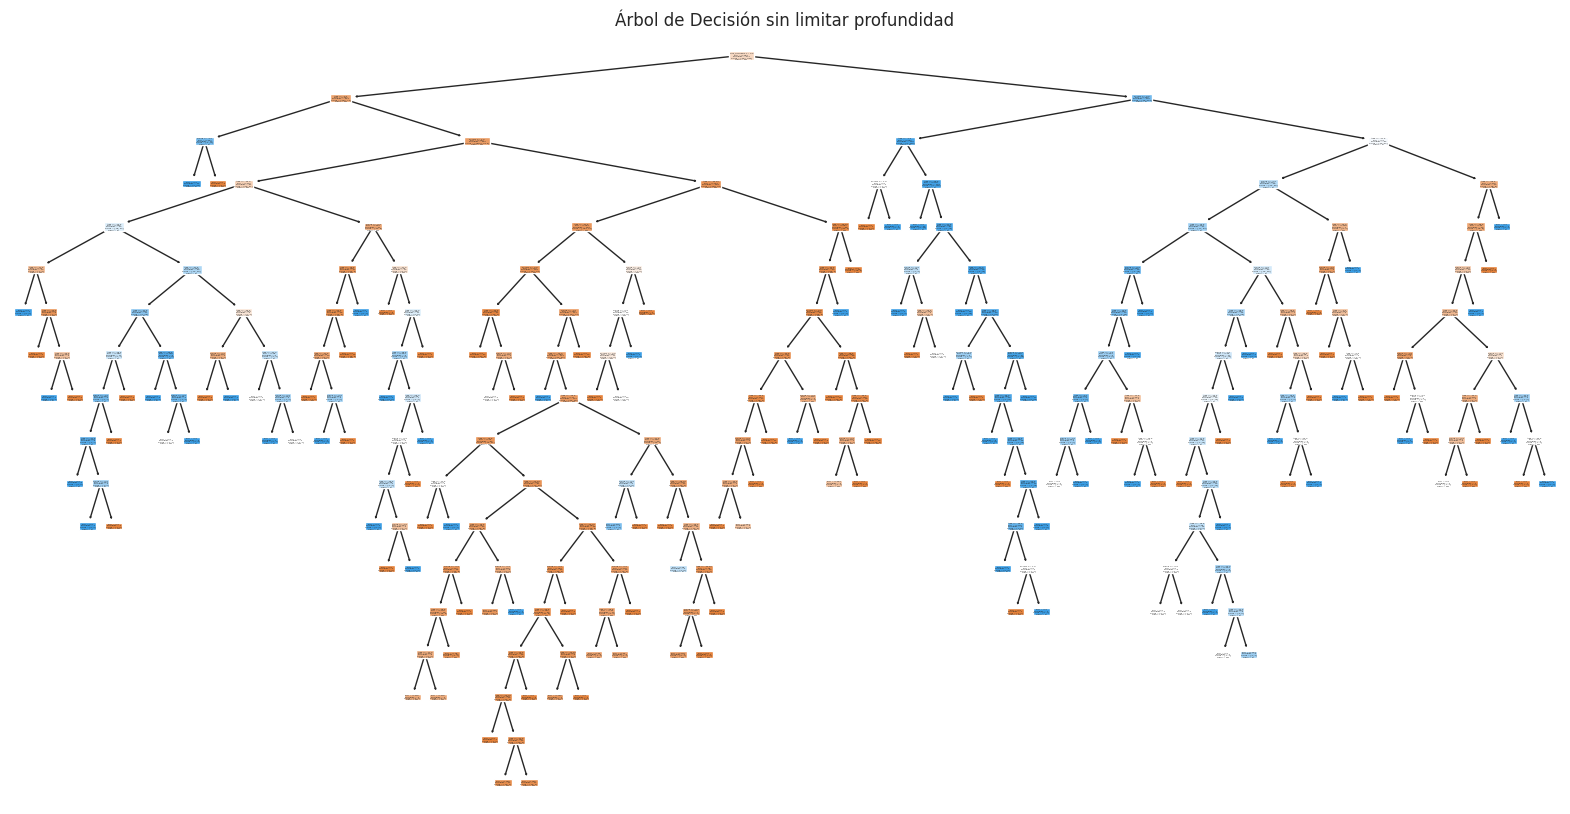

In [ ]:
# División en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creamos y entrenamos el árbol de decisión sin restricciones
arbol_completo = DecisionTreeClassifier(random_state=42)
arbol_completo.fit(X_train, y_train)

# Visualizamos el árbol
plt.figure(figsize=(20, 10))
plot_tree(arbol_completo, feature_names=X.columns, class_names=["No", "Sí"], filled=True)
plt.title("Árbol de Decisión sin limitar profundidad")
plt.show()


## Evaluación del árbol de decisión completo

A continuación vamos a evaluar el rendimiento del árbol completo, utilizando las métricas habituales:

- **Precisión (accuracy)**
- **Precision, recall y F1-score**
- **Matriz de confusión**

Esto nos permitirá ver si el árbol que parece tan detallado realmente logra generalizar bien al conjunto de prueba.


In [ ]:
# Predicciones del árbol sobre el conjunto de prueba
y_pred_completo = arbol_completo.predict(X_test)

# Reporte de clasificación
print("Reporte de clasificación - Árbol sin restricciones:\n")
print(classification_report(y_test, y_pred_completo))

# Matriz de confusión
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred_completo))


Reporte de clasificación - Árbol sin restricciones:

              precision    recall  f1-score   support

           0       0.80      0.78      0.79        87
           1       0.67      0.70      0.68        56

    accuracy                           0.75       143
   macro avg       0.74      0.74      0.74       143
weighted avg       0.75      0.75      0.75       143

Matriz de confusión:
[[68 19]
 [17 39]]


## Interpretación del árbol sin restricciones

El árbol entrenado sin limitar su profundidad alcanzó una **precisión general (accuracy)** del **75%** sobre el conjunto de prueba, un valor aceptable, aunque no significativamente mejor que otros modelos vistos anteriormente.

Si analizamos por clase:

- Para la clase `0` (no sobrevivió), la **precisión fue de 0.80** y el **recall de 0.78**, lo que indica que el modelo detecta correctamente la mayoría de las personas que no sobrevivieron.
- Para la clase `1` (sí sobrevivió), la precisión bajó a **0.67**, y el recall a **0.70**, lo que muestra un rendimiento más limitado para esta categoría.

La **matriz de confusión** muestra:
- 68 verdaderos negativos (predijo 0 y era 0).
- 19 falsos positivos (predijo 1, pero era 0).
- 39 verdaderos positivos.
- 17 falsos negativos.

Aunque el árbol aprendió reglas detalladas, no se observa una mejora significativa respecto a modelos más simples. Esto **sugiere un posible sobreajuste**: el árbol parece haber aprendido muchos patrones específicos del conjunto de entrenamiento, pero no logró generalizar mejor en el conjunto de prueba.

A continuación, vamos a limitar la profundidad del árbol y comparar los resultados.


## Entrenamiento de un árbol con profundidad limitada (max_depth = 3)

Vamos a crear un nuevo árbol de decisión limitando su **profundidad máxima a 3 niveles**. Esto nos permitirá comparar el rendimiento frente al árbol anterior y ver cómo afecta esta restricción a:

- La **generalización** del modelo.
- La **simplicidad** y legibilidad del árbol.
- La **precisión** y tipo de errores cometidos.

Después de entrenarlo, también lo visualizaremos para apreciar su estructura más compacta.


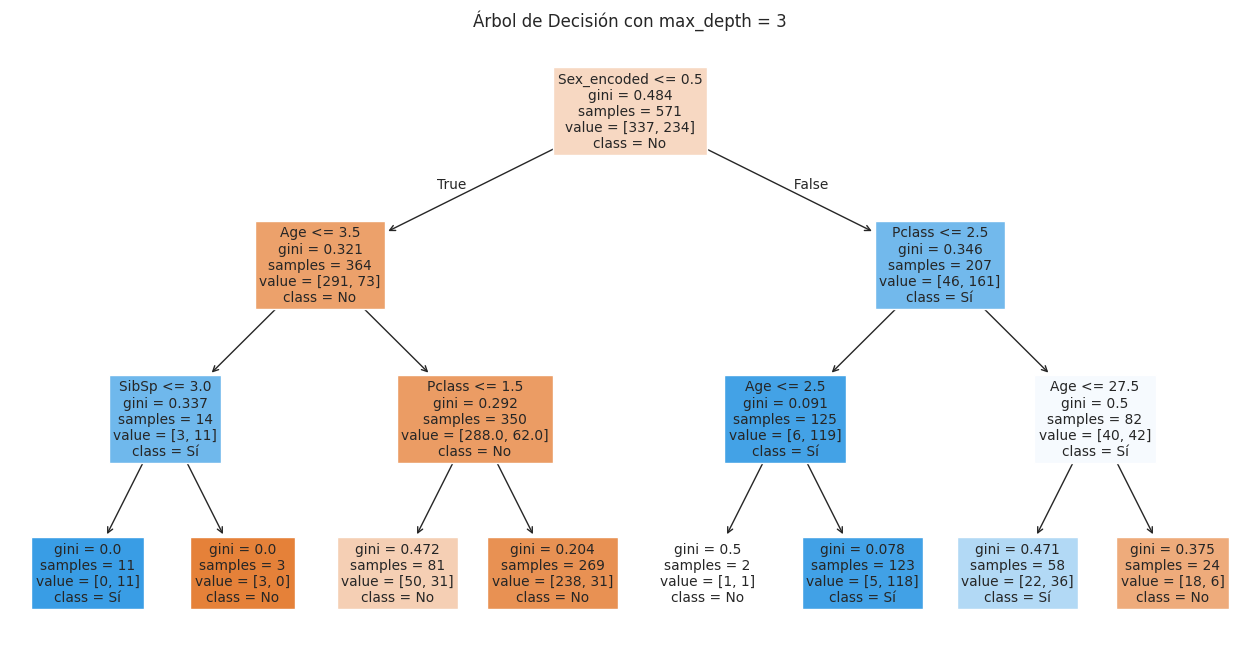

In [ ]:
# Creamos y entrenamos un árbol con profundidad máxima de 3
arbol_podado = DecisionTreeClassifier(max_depth=3, random_state=42)
arbol_podado.fit(X_train, y_train)

# Visualizamos el árbol limitado
plt.figure(figsize=(16, 8))
plot_tree(arbol_podado, feature_names=X.columns, class_names=["No", "Sí"], filled=True)
plt.title("Árbol de Decisión con max_depth = 3")
plt.show()


## Evaluación del árbol de decisión limitado (profundidad = 3)

Ahora vamos a ver cómo se desempeña este árbol más simple en términos de precisión, recall y matriz de confusión.

Esto nos permitirá comparar su rendimiento con el del árbol sin restricciones y analizar si hubo una pérdida de exactitud a cambio de una mayor capacidad de generalización y menor complejidad.


In [ ]:
# Predicciones del árbol limitado sobre el conjunto de prueba
y_pred_podado = arbol_podado.predict(X_test)

# Reporte de clasificación
print("Reporte de clasificación - Árbol con max_depth=3:\n")
print(classification_report(y_test, y_pred_podado))

# Matriz de confusión
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred_podado))


Reporte de clasificación - Árbol con max_depth=3:

              precision    recall  f1-score   support

           0       0.77      0.83      0.80        87
           1       0.69      0.61      0.65        56

    accuracy                           0.74       143
   macro avg       0.73      0.72      0.72       143
weighted avg       0.74      0.74      0.74       143

Matriz de confusión:
[[72 15]
 [22 34]]


## Comparación de modelos: sin restricciones vs. max_depth = 3

El árbol limitado a `max_depth = 3` obtuvo una precisión general (**accuracy**) del **74%**, muy similar al modelo sin restricciones, que había alcanzado un 75%. Esto ya nos da una señal positiva: **una estructura más simple logró un rendimiento casi equivalente**.

Si miramos los detalles:

- **Clase 0 (no sobrevivió)**: el árbol podado logró **mejor recall (0.83)**, aunque bajó un poco la precisión (0.77).
- **Clase 1 (sí sobrevivió)**: el rendimiento fue algo menor que el árbol completo (recall de 0.61 vs. 0.70), lo que indica que **detectó menos casos positivos**.

La matriz de confusión también muestra una **mayor cantidad de falsos negativos** (22 en lugar de 17), pero una mejora en los verdaderos negativos.

Este tipo de árbol tiene varias ventajas:
- Es **mucho más fácil de interpretar**.
- Es **menos propenso al sobreajuste**.
- Permite explicar las decisiones con reglas simples, ideales para comunicar resultados a personas no técnicas.

**Si bien el árbol podado es ligeramente menos preciso, es más simple y estable**, lo cual puede ser deseable dependiendo del contexto del problema.

Esta comparación ayuda a reflexionar sobre el equilibrio entre **precisión y simplicidad**: a veces, un modelo más simple puede ser más útil, aunque no sea el más exacto.



## Conclusión y cierre

En este cuaderno entrenamos, visualizamos y evaluamos modelos de **árboles de decisión** aplicados al problema de predicción de supervivencia en el Titanic.

Primero construimos un árbol sin restricciones, que logró una precisión razonable, pero mostró señales de sobreajuste. Luego entrenamos un árbol más limitado (`max_depth = 3`), con reglas más generales y fáciles de interpretar, que logró un rendimiento muy similar, pero con mayor estabilidad.

En el próximo cuaderno analizaremos los **bosques aleatorios (Random Forests)**, una técnica que toma lo mejor de los árboles individuales, pero reduce su variabilidad y mejora su capacidad predictiva.
